# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.utils import Sequence

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# Import Dataset

In [2]:
!git clone https://github.com/am1tyadav/superhero
with open('superhero/superheroes.txt') as f:
    data = f.read()

Cloning into 'superhero'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), 47.06 KiB | 523.00 KiB/s, done.


# Preprocessing

In [3]:
tokenizer = preprocessing.text.Tokenizer(
    filters ='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~',
    split='\n',
)

tokenizer.fit_on_texts(data)
names = data.splitlines()
names[:3]

['jumpa\t', 'doctor fate\t', 'starlight\t']

In [4]:
char_to_index = tokenizer.word_index
index_to_char = {v: k for k, v in char_to_index.items()}
vocabulary_size = len(char_to_index) + 1
print('Vocabulary Size: {}'.format(vocabulary_size))

Vocabulary Size: 29


In [5]:
def name_to_sequence(name):
    return [tokenizer.texts_to_sequences(c)[0][0] for c in name]

def sequence_to_name(sequence):
    return ''.join([index_to_char[i] for i in sequence if i > 0])

assert sequence_to_name(name_to_sequence(names[0])) == names[0]

In [6]:
sequences = []
for name in names:
    sequence = name_to_sequence(name)
    if len(sequence) > 1:
        sequences += [sequence[:i] for i in range(2, len(sequence) + 1)]
max_len = max([len(sequence) for sequence in sequences])
padded_sequences =preprocessing.sequence.pad_sequences(sequences, maxlen=max_len)
padded_sequences[:3], padded_sequences.shape

(array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 25,
         16],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 25, 16,
         12],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 25, 16, 12,
         20]], dtype=int32),
 (88279, 33))

# Creating Datasets

In [7]:
data = padded_sequences[:, :-1]
labels = padded_sequences[:, -1]
data.shape, labels.shape

((88279, 32), (88279,))

In [8]:
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, shuffle=True, train_size=0.9)
train_data.shape, train_labels.shape, val_data.shape, val_labels.shape

((79451, 32), (79451,), (8828, 32), (8828,))

In [9]:
class DataGenerator(Sequence):
    def __init__(self, data, labels, batch_size=128, shuffle=True):
        super().__init__()
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        key_array = []
        self.key_array = np.arange(self.data.shape[0], dtype=np.uint32)
        self.on_epoch_end()

    def __len__(self):
        return len(self.key_array) // self.batch_size

    def __getitem__(self, index):
        keys = self.key_array[index * self.batch_size: (index + 1) * self.batch_size]
        x = np.asarray(self.data[keys], dtype=np.float32)
        y = np.asarray(self.labels[keys], dtype=np.float32)
        return x, y

    def on_epoch_end(self):
        if self.shuffle:
            self.key_array = np.random.permutation(self.key_array)
      


train_generator = DataGenerator(train_data, train_labels, 1024, True)

# Model

In [10]:
model = Sequential([
    Embedding(vocabulary_size, 64, input_length=max_len - 1),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(vocabulary_size, activation='softmax')
])

model.summary()

2023-01-21 23:52:00.368783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-21 23:52:00.459676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-21 23:52:00.460538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-21 23:52:00.462419: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 64)            1856      
_________________________________________________________________
lstm (LSTM)                  (None, 32, 128)           98816     
_________________________________________________________________
dropout (Dropout)            (None, 32, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0

# Train & Validation

In [11]:
epochs = 200
num_train_batches = len(train_generator)

def scheduler(epoch, lr):
    if epoch < 50:
        return lr
    return lr * tf.math.exp(-0.03)

def sparse_top_k_categorical_crossentropy(y_true, y_pred, k = 5):
    np_y_pred = y_pred
    if not isinstance(y_pred, np.ndarray):
        np_y_pred = y_pred.numpy()
    loss = sparse_categorical_crossentropy(y_true, y_pred)
    indices = np.argsort(np_y_pred)[:, :k]
    top_k_pred = np_y_pred[:, indices]
    for i in range(y_true.shape[0]):
        if y_true[i] in top_k_pred[i]:
            keras.backend.set_value(loss[i], 0)
    return tf.math.reduce_sum(loss)

optimizer = Adam(learning_rate=0.02)
top3_acc = SparseTopKCategoricalAccuracy(k=3)

train_loss = np.zeros(shape=(epochs,), dtype=np.float32)
train_acc = np.zeros(shape=(epochs,), dtype=np.float32)
val_loss = np.zeros(shape=(epochs,))
val_acc = np.zeros(shape=(epochs,))

for epoch in range(epochs):
    epoch_lr = scheduler(epoch, optimizer.learning_rate).numpy()
    keras.backend.set_value(optimizer.learning_rate, epoch_lr)

    for batch in range(num_train_batches):
        x, y_true = train_generator[batch]

        batch_loss = 0
        batch_acc = 0
        
        with tf.GradientTape() as tape:
            y_pred = model(x, training=True)
            batch_loss += sparse_top_k_categorical_crossentropy(y_true, y_pred, 3)
            top3_acc.update_state(y_true, y_pred)
            batch_acc += top3_acc.result().numpy() * len(y_true)
        
        gradient = tape.gradient(batch_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradient, model.trainable_variables))

        train_loss[epoch] += batch_loss
        train_acc[epoch] += batch_acc
    
    train_loss[epoch] /= train_generator.data.shape[0]
    train_acc[epoch] /= train_generator.data.shape[0]

    train_generator.on_epoch_end()

    y_pred = model.predict(val_data, verbose=0)
    val_loss[epoch] = sparse_top_k_categorical_crossentropy(val_labels, y_pred, 3) / len(y_pred)
    top3_acc.update_state(val_labels, y_pred)
    val_acc[epoch] = top3_acc.result().numpy()

    print('Epoch {}/{}'.format(epoch + 1, epochs))
    print('loss: {:0.4f} - accuracy: {:0.4f} - val loss: {:0.4f} - val accuracy: {:0.4f} - lr: {:0.5f}'.format(train_loss[epoch], train_acc[epoch], val_loss[epoch], val_acc[epoch], optimizer.learning_rate.numpy()) )     

2023-01-21 23:52:04.592789: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2023-01-21 23:52:10.374875: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
loss: 2.9952 - accuracy: 0.2598 - val loss: 2.9887 - val accuracy: 0.2797 - lr: 0.02000
Epoch 2/200
loss: 2.8591 - accuracy: 0.2906 - val loss: 2.7235 - val accuracy: 0.3189 - lr: 0.02000
Epoch 3/200
loss: 2.6965 - accuracy: 0.3331 - val loss: 2.6399 - val accuracy: 0.3525 - lr: 0.02000
Epoch 4/200
loss: 2.6314 - accuracy: 0.3605 - val loss: 2.5486 - val accuracy: 0.3762 - lr: 0.02000
Epoch 5/200
loss: 2.5776 - accuracy: 0.3819 - val loss: 2.5024 - val accuracy: 0.3944 - lr: 0.02000
Epoch 6/200
loss: 2.5414 - accuracy: 0.3979 - val loss: 2.4440 - val accuracy: 0.4083 - lr: 0.02000
Epoch 7/200
loss: 2.5159 - accuracy: 0.4104 - val loss: 2.4266 - val accuracy: 0.4195 - lr: 0.02000
Epoch 8/200
loss: 2.4924 - accuracy: 0.4205 - val loss: 2.3967 - val accuracy: 0.4287 - lr: 0.02000
Epoch 9/200
loss: 2.4744 - accuracy: 0.4290 - val loss: 2.3784 - val accuracy: 0.4365 - lr: 0.02000
Epoch 10/200
loss: 2.4628 - accuracy: 0.4361 - val loss: 2.3631 - val accuracy: 0.4430 - lr: 0.02000

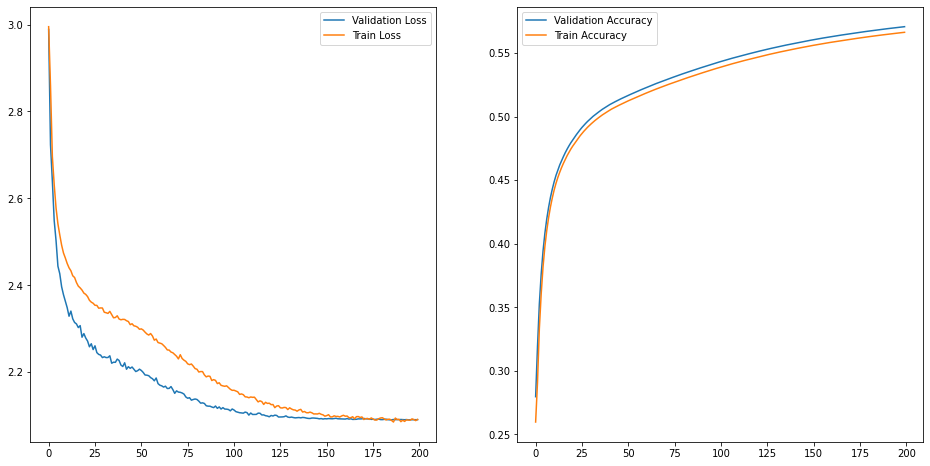

In [12]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.plot(range(epochs), train_loss, label='Train Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.plot(range(epochs), train_acc, label='Train Accuracy')
plt.legend()
plt.show()

# Generate Names!

In [13]:
def generate_names(seed):
    while seed[-1] != '\t':
        seq = name_to_sequence(seed)
        padded = preprocessing.sequence.pad_sequences([seq], maxlen=max_len - 1, truncating='pre')
        pred = model.predict(padded)[0]
        top3 = tf.math.top_k(pred, k = 3).indices.numpy()
        pred_char = index_to_char[top3[np.random.choice(3, 1)][0]]  
        seed += pred_char
    print(seed)

In [14]:
generate_names('a')

alasen	


In [15]:
generate_names('super')

supermire manse	


In [16]:
generate_names('star')

stareanssantin	


In [17]:
generate_names('silver')

silver	
